# 第9章 混合モデルとEM

この章では，離散な潜在変数 $\mathbf{z}$ を用いて同時分布 $p(\mathbf{x}, \mathbf{z})$ が定義できる状況を考え，その中でもとくに *混合モデル (mixture model)* について掘り下げる．

In [1]:
import tensorflow as tf
import edward as ed

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Set1')

%matplotlib inline

## K-means

### データ

データには Old Fiathful 間欠泉データを用いる．クラスタリングのために正規化を行っておく．

In [2]:
X_faithful = np.loadtxt("./data/faithful.csv", delimiter=",", skiprows=1)
X_faithful = (X_faithful - X_faithful.mean(axis=0)) / X_faithful.std(axis=0)

どんなデータか確かめるためにプロット

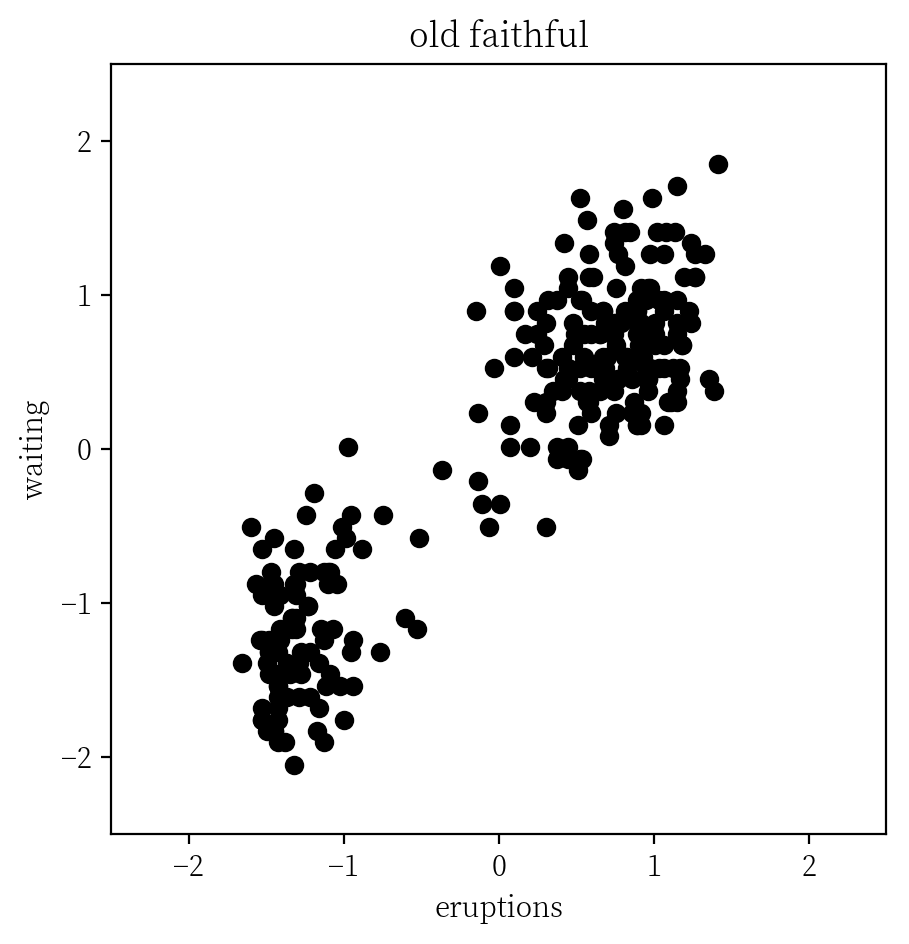

In [3]:
def plot_faithful(X, labels=None, ax=None, show_title=True):
    if ax is None:
        ax = plt.gca()
    ax.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
    if show_title:
        ax.set(xlabel='eruptions', ylabel='waiting', title='old faithful')
    if labels is not None:
        for c in range(2):
            X_ = X[labels == c, :]
            ax.scatter(X_[:,0], X_[:,1], color=cmap(c))
    else:
        ax.scatter(X[:,0], X[:,1], color='k')

plt.figure(figsize=(5,5))    
plot_faithful(X_faithful)
plt.show()

まずは sklearn を使うとどうなるかやってみよう

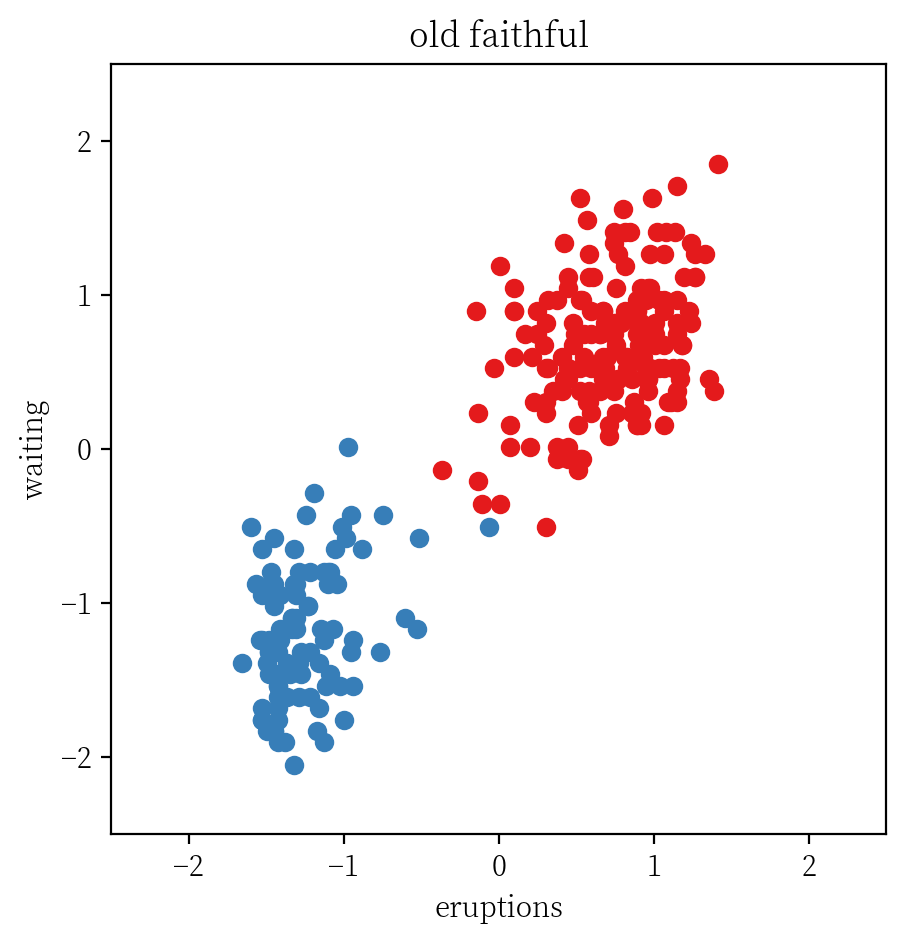

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_faithful)
labels = kmeans.predict(X_faithful)

plt.figure(figsize=(5,5))
plot_faithful(X_faithful, labels)
plt.show()

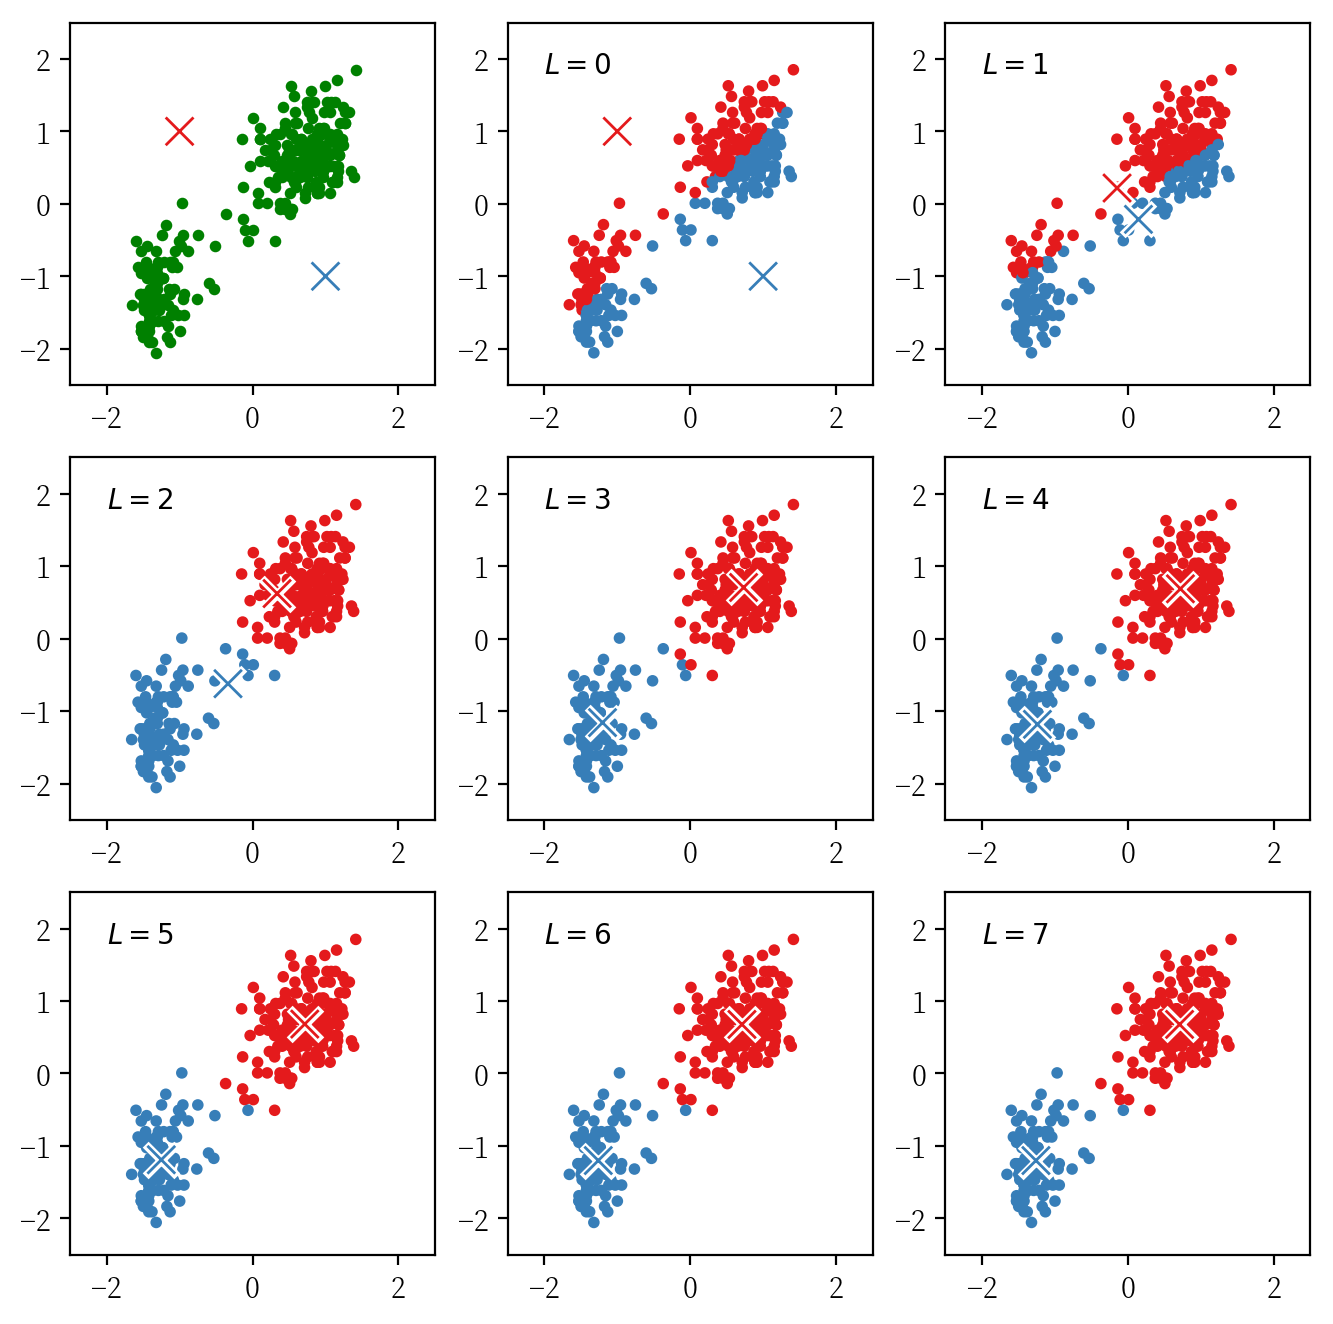

In [5]:
# X         : matrix with shape (n_samples, n_features)
# centroids : matrix with shape (n_clusters, n_features)
# labels    : array like object with shape (n_samples, )

class PrmlKMeans():
    def __init__(self, X, centroids):
        self.X = X
        self.centroids = np.array(centroids, dtype=np.float32)
        self.n_samples, self.n_features = X.shape
        self.n_clusters, D = self.centroids.shape
        assert(D == self.n_features)
        self.labels = np.zeros(self.n_samples)
        self.L = 0
        
    def update_labels(self):
        L = np.empty((self.n_samples, self.n_clusters))
        for n in range(self.n_samples):
            L[n] = [np.sum((self.X[n] - self.centroids[k])**2) for k in range(self.n_clusters)]
        self.labels = np.argmin(L, axis=1)
        
    def update_centroids(self):
        for k in range(self.n_clusters):
            self.centroids[k] = self.X[self.labels == k, :].mean(axis=0)
    
    def calc_step(self):
        self.update_labels()
        self.update_centroids()
        self.L += 1
            
    def plot(self, ax=None, labeled=True):
        if ax is None:
            ax = plt.gca()
        if labeled:
            self.update_labels()
            ax.scatter(self.X[:,0], self.X[:,1], s=10, c=[cmap(l) for l in self.labels])
        else:
            ax.scatter(self.X[:,0], self.X[:,1], s=10, c='green')
        ax.scatter(self.centroids[:,0], self.centroids[:,1],
               s=130, marker='x', c='white', lw=3)
        ax.scatter(self.centroids[:,0], self.centroids[:,1],
               s=100, marker='x', c=cmap(range(self.n_clusters)), lw=1)

centroids = np.array([[-1, 1], [1, -1]])
kmeans = PrmlKMeans(X_faithful, centroids)

L = [None, 0, 1, 2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(fig.get_axes()):
    ax.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
    if i == 0:
        kmeans.plot(ax, labeled=False)
    else:
        while kmeans.L < L[i]:
            kmeans.calc_step()
        kmeans.plot(ax)
        ax.text(-2, 1.8, '$ L = %d $' % kmeans.L)
        
plt.show()

# 図9.5

混合ガウス分布の負担率についてのプロット

#### 気づいたこと

* `cmap` で取得した色は，`shape=(4,)` の `np.array` になってるので，色を混ぜるとき便利
* color map は `plt.cm.*` にデフォルトが用意されてある
    * Set1, tab10 あたりが無難かな

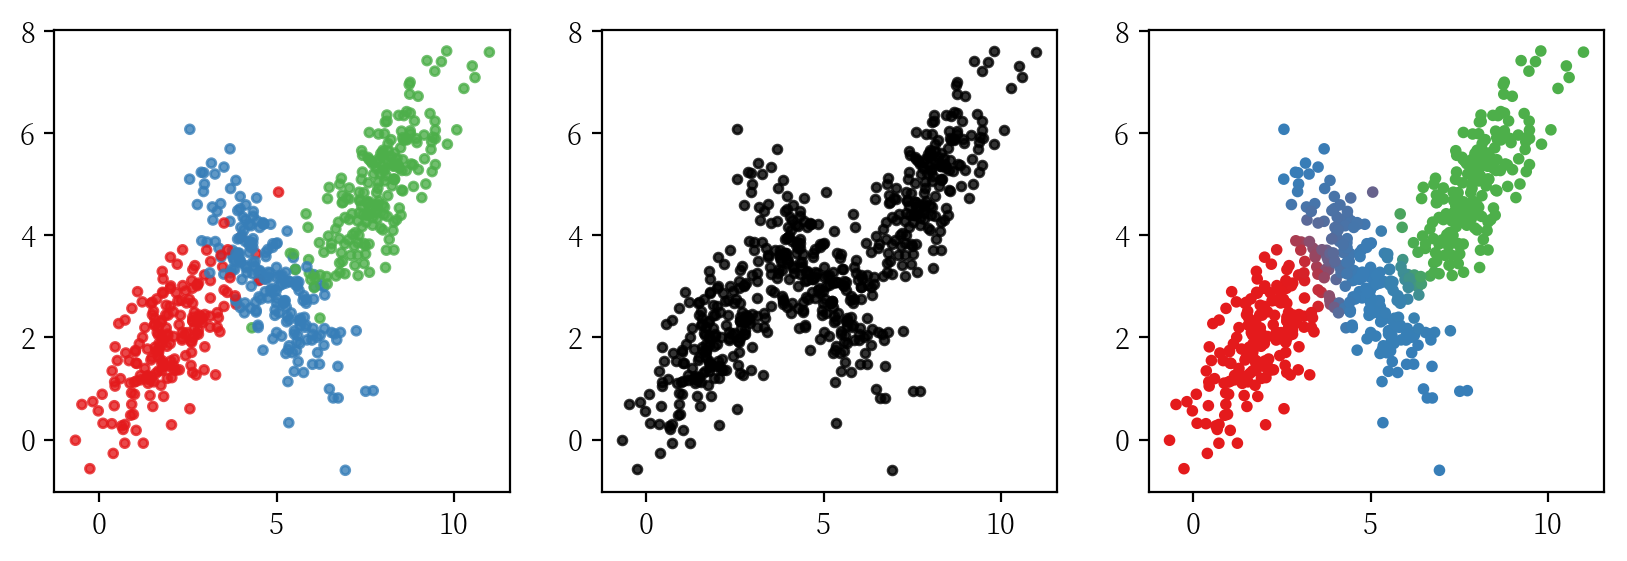

In [6]:
from scipy.stats import multivariate_normal

N = 600
K = 3

# z の事前分布
pi = np.array([1.0/3.]*3)

mu = np.array([[2, 2], [5, 3], [8, 5]])
Sigma = np.array([
    [[1, 0.75],[0.75, 1]],
    [[1, -0.75],[-0.75,1]],
    [[1, 0.75],[0.75, 1]]
])

# データの生成
Z = np.random.choice(3, size=N, p=pi)
X = np.array([np.random.multivariate_normal(m, S) for m,S in zip(mu[Z], Sigma[Z])])

r_colors = []
# 負担率 (responsibility)
for n in range(X.shape[0]):
    r_nk = [pi[k] * multivariate_normal(mu[k], Sigma[k]).pdf(X[n]) for k in range(K)]
    r_nk = r_nk / sum(r_nk)
    c_nk = cmap([0,1,2]).T.dot(r_nk)
    r_colors.append(c_nk[:3])

fig, axes = plt.subplots(1, 3, figsize=(10,3))

# (a) 完全データのプロット
axes[0].scatter(X[:,0], X[:,1], s=10, alpha=0.8, c=[cmap(z) for z in Z])
# (b) 不完全データのプロット
axes[1].scatter(X[:,0], X[:,1], s=10, alpha=0.8, c='k')
# (c) 負担率による色付け
axes[2].scatter(X[:,0], X[:,1], s=10, c=r_colors)

plt.show()

# 図9.8

EMアルゴリズムを Old Faithful 間欠泉データに適応する

#### memo

* 2 次元ガウス分布において，$\alpha$ % のデータ点が含まれるであろう範囲を表す楕円を「$\alpha$ ％-信頼楕円」と呼ぶ．
* 楕円の描写には `matplotlib.patches.Ellipse` が使える


'NotoSerifCJKjp-Light.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


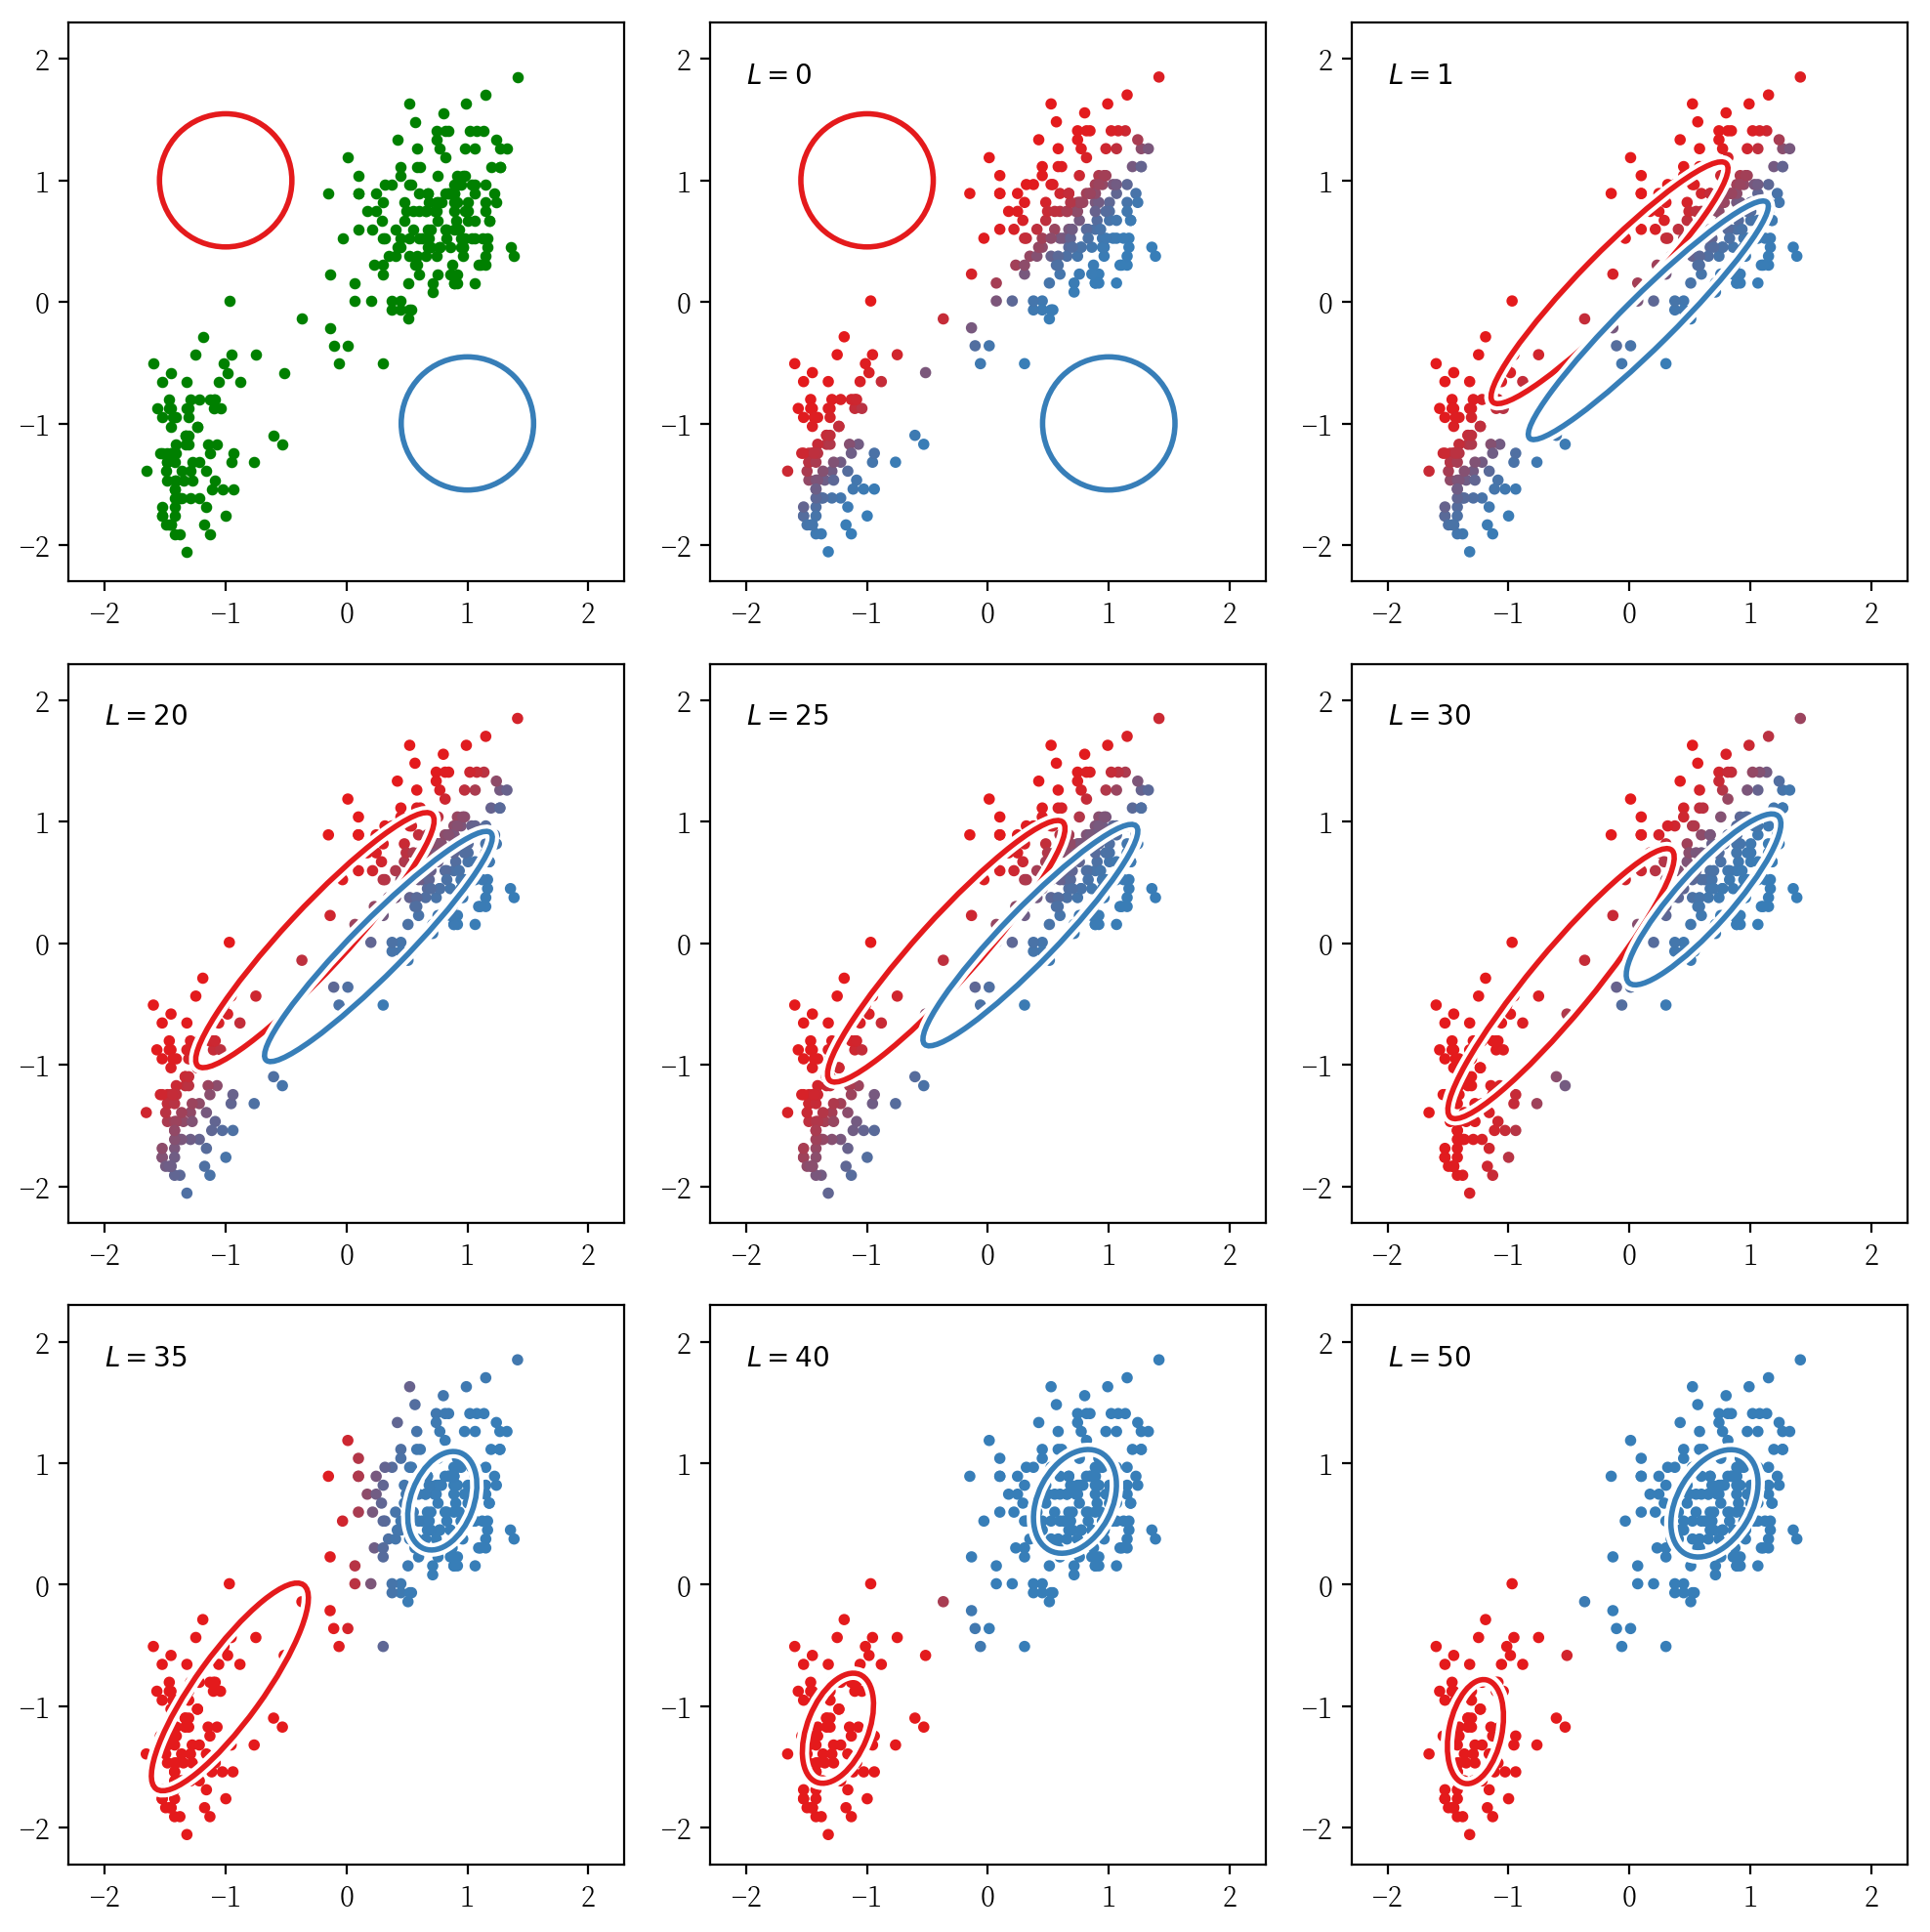

In [7]:
from scipy.stats import multivariate_normal
from matplotlib import patches

class MixGauss():
    def __init__(self, X, pis, means, covs):
        self.X = X
        self.N, self.D = X.shape
        self.means = np.array(means, dtype=np.float32)
        self.covs  = np.array(covs, dtype=np.float32)
        self.pis   = np.array(pis, dtype=np.float32)
        self.K = self.means.shape[0]
        # 負担率
        self.R = np.empty(shape=(self.N, self.K))
        self.L = 0
        
    def get_ellipse(self, cov, std=1):
        '''二次元ガウス分布の信頼楕円を計算する
        '''
        eigvalues, V = np.linalg.eigh(cov)
        order = eigvalues.argsort()[::-1]
        eigvalues, V = eigvalues[order], V[:,order]
        eigvalues = np.sqrt(eigvalues)
        w = 2 * eigvalues[0] * std
        h = 2 * eigvalues[1] * std
        vec = V[:,0]
        if vec[0] < 0:
            vec = vec * [-1, 1]
        deg = np.degrees(np.arccos(vec.dot([1,0])))
        return w, h, deg
        
    def plot_gauss(self, ax=None):
        '''ガウス分布をプロットする
        '''
        if ax is None:
            ax = plt.gca()
        for k in range(self.K):
            w, h, deg = self.get_ellipse(self.covs[k])
            xy = self.means[k].copy()
            e = patches.Ellipse(xy=xy, width=w, height=h, angle=deg,
                                ec='white', lw=5, fill=False)
            ax.add_patch(e)
            e = patches.Ellipse(xy=xy, width=w, height=h, angle=deg,
                                ec=cmap(k), lw=2, fill=False)
            ax.add_patch(e)
            
    def plot_scatter(self, ax=None, labels=None, resp_color=False):
        if ax is None:
            ax = plt.gca()
            
        if labels:
            colors = [cmap(l) for l in labels]
            ax.scatter(self.X[:,0], self.X[:,1], s=10, c=colors)
        elif resp_color == True:
            self.e_step()
            cmap_k = cmap(range(self.K))
            colors = [cmap_k.T.dot(self.R[n])[:3] for n in range(self.N)]
            ax.scatter(self.X[:,0], self.X[:,1], s=10, c=colors)
        else:
            ax.scatter(self.X[:,0], self.X[:,1], s=10, c='green')
        
    def e_step(self):
        for k in range(self.K):
            self.R[:,k] = multivariate_normal(self.means[k], self.covs[k]).logpdf(self.X)
        self.R += np.log(self.pis[k])
        self.R = np.exp(self.R)
        self.R /= self.R.sum(axis=1)[:,None]
            
    def m_step(self):
        Nk = self.R.sum(axis=0)
        for k in range(self.K):
            self.means[k] = (self.X.T * self.R[:,k]).sum(axis=1).T / Nk[k]
            Xm = self.X - self.means[k]
            self.covs[k] = (Xm.T * self.R[:,k]).dot(Xm) / Nk[k]
        self.pis = Nk / N
        
    def calc_step(self):
        self.e_step()
        self.m_step()
        self.L += 1

pis = np.array([0.5, 0.5])
means = np.array([[-1, 1], [1, -1]])
covs = np.array([np.identity(2)*.3, np.identity(2)*.3])
mixgauss = MixGauss(X_faithful, pis, means, covs)

# Learning steps in which we want to plot.
L = [None, 0, 1, 20, 25, 30, 35, 40, 50]
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i, ax in enumerate(fig.get_axes()):
    ax.set(xlim=(-2.3, 2.3), ylim=(-2.3, 2.3))
    if i == 0:
        mixgauss.plot_scatter(ax)
        mixgauss.plot_gauss(ax)
    else:
        while mixgauss.L < L[i]:
            mixgauss.calc_step()
        mixgauss.plot_scatter(ax, resp_color=True)
        mixgauss.plot_gauss(ax)
        ax.text(-2, 1.8, '$ L = %d $' % mixgauss.L)
        
plt.tight_layout()
plt.savefig('output/fig09.8.pdf')

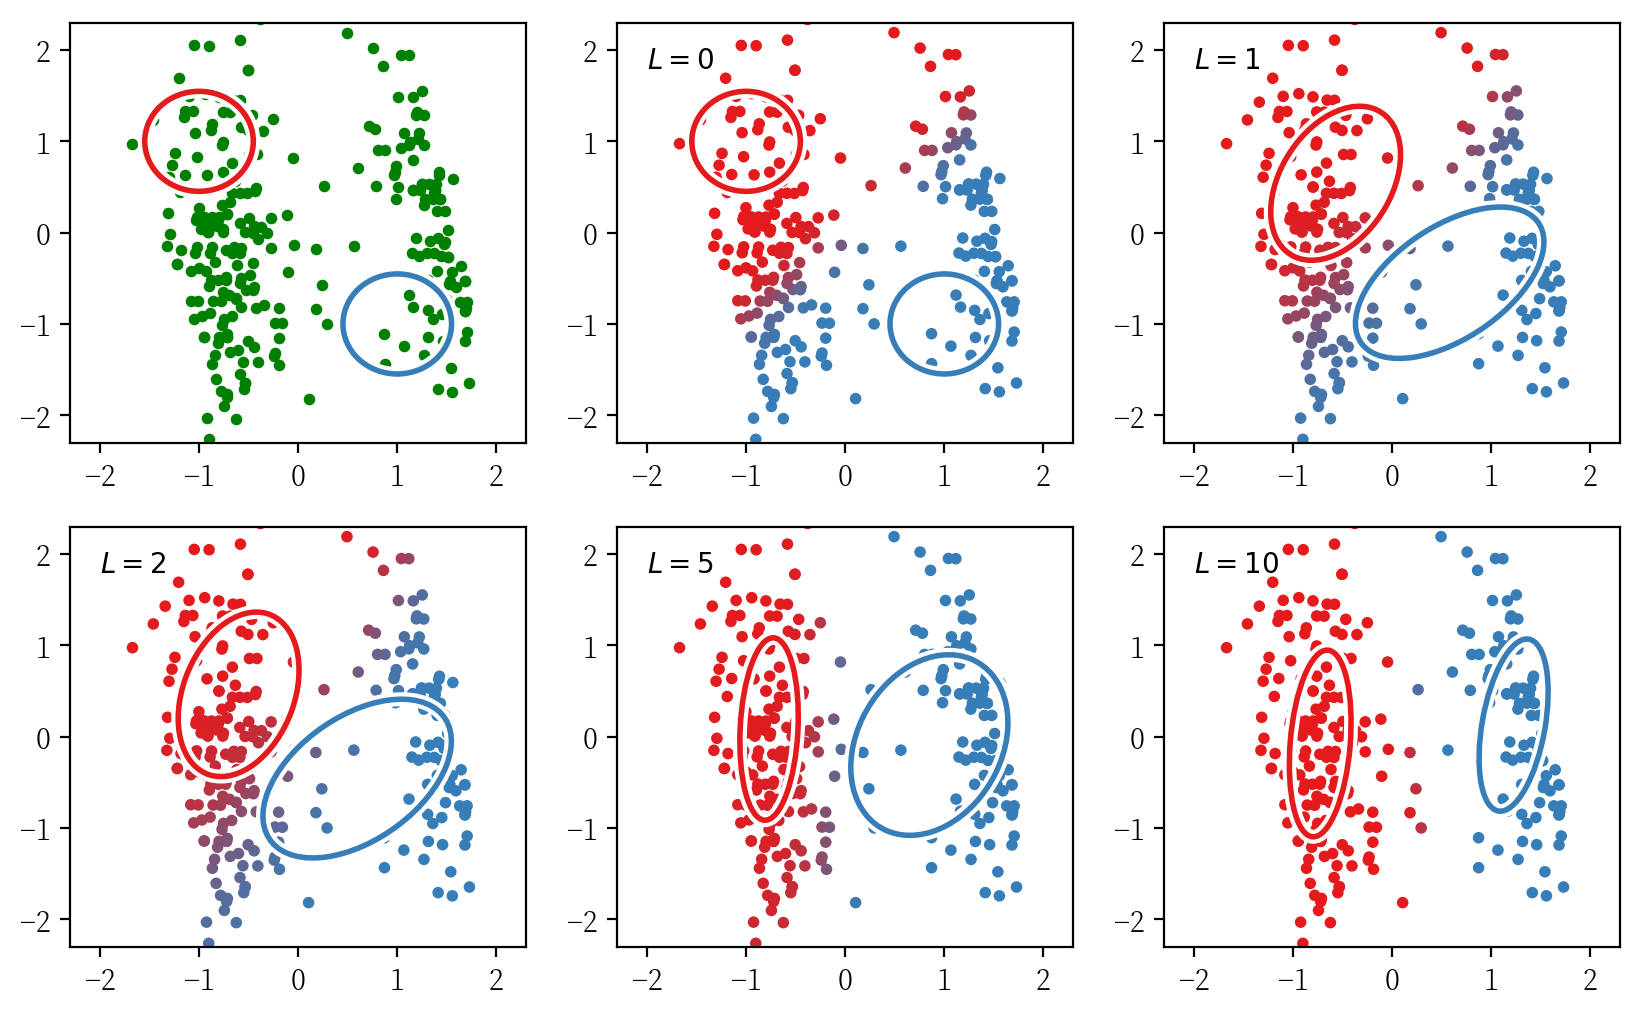

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
X_faithful_whiten = pca.fit_transform(X_faithful)
mixgauss = MixGauss(X_faithful_whiten, pis, means, covs)

# Learning steps in which we want to plot.
L = [None, 0, 1, 2, 5, 10]
fig, axes = plt.subplots(2, 3, figsize=(10,6))
for i, ax in enumerate(fig.get_axes()):
    ax.set(xlim=(-2.3, 2.3), ylim=(-2.3, 2.3))
    if i == 0:
        mixgauss.plot_scatter(ax)
        mixgauss.plot_gauss(ax)
    else:
        while mixgauss.L < L[i]:
            mixgauss.calc_step()
        mixgauss.plot_scatter(ax, resp_color=True)
        mixgauss.plot_gauss(ax)
        ax.text(-2, 1.8, '$ L = %d $' % mixgauss.L)

In [14]:
A = np.array([
    [1, 0.8],[0.8, 1]
])
1.0/ np.linalg.inv(A)[1][1]

0.35999999999999993